# PA004: Health Insurance cross sell

##  Planejamento da solução (IOT)

### Input

### Output

### Tasks

# 0.0. IMPORTS

In [1]:
import seaborn        as sns
import pandas         as pd
import psycopg2       as pg
import numpy          as np
import scikitplot     as skplt

from matplotlib                    import pyplot                   as plt


from IPython.core.display          import HTML

from sklearn                       import preprocessing            as pp
from sklearn                       import model_selection          as ms
from sklearn                       import ensemble                 as en
from sklearn                       import neighbors                as nk   

from sklearn                       import linear_model             as lm
import warnings

warnings.filterwarnings("ignore")

## 0.1 Loading Data - Postgres

In [2]:
path = '/home/pedrosa/repositorio/health_insurance'

In [3]:
#  # Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

In [4]:
# conn = pg.connect(user = username, password = pwd, host = host, port = port, database = database)

# query_schema = '''
#     SELECT *
#     FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
#                         INNER JOIN pa004.insurance i on (u.id = i.id)
# '''

# df_raw = pd.read_sql(query_schema, conn)

# conn.close()

# df_raw.to_pickle(path + '/data/raw/df_raw.pkl')

In [5]:
df1 = pd.read_pickle(path + '/data/raw/df_raw.pkl') 

## 0.2 Helper Functions

In [6]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.8f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [7]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# 1.0. Data Description


## 1.1. Organize columns

In [8]:
 # removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

## 1.2. Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [10]:
df1.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum() 

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.5.1 Numerical Attributes


In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000000,381109.00000000,381108.00000000,190555.00000000,190555.00000000,110016.69186992,-0.00000000,-1.20000000
1,age,20.00000000,85.00000000,65.00000000,38.82258357,36.00000000,15.51159067,0.67253900,-0.56565507
2,region_code,0.00000000,52.00000000,52.00000000,26.38880740,28.00000000,13.22987067,-0.11526641,-0.86785712
3,policy_sales_channel,1.00000000,163.00000000,162.00000000,112.03429465,133.00000000,54.20392366,-0.90000812,-0.97081018
4,driving_license,0.00000000,1.00000000,1.00000000,0.99786938,1.00000000,0.04610948,-21.59518153,464.35430215
5,previously_insured,0.00000000,1.00000000,1.00000000,0.45821012,0.00000000,0.49825055,0.16774712,-1.97187125
6,annual_premium,2630.00000000,540165.00000000,537535.00000000,30564.38958146,31669.00000000,17213.13247397,1.76608721,34.00456870
7,vintage,10.00000000,299.00000000,289.00000000,154.34739668,154.00000000,83.67119385,0.00302952,-1.20068804
8,response,0.00000000,1.00000000,1.00000000,0.12256336,0.00000000,0.32793533,2.30190580,3.29878763


# 2.0. Feature Engineering


In [14]:
df2 = df1.copy()

In [15]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,< 1 Year,Yes,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,1-2 Year,No,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,< 1 Year,No,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,< 1 Year,No,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,1-2 Year,Yes,0,42297.00000000,264,0


In [16]:
# vehicule age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehiculde damage
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes' : 1 , 'No' : 0})


# 3.0. Data Filtering


In [17]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [18]:
df4 = df3.copy()

## 4.1. Univariate Analysis


In [19]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

<AxesSubplot:xlabel='response', ylabel='age'>

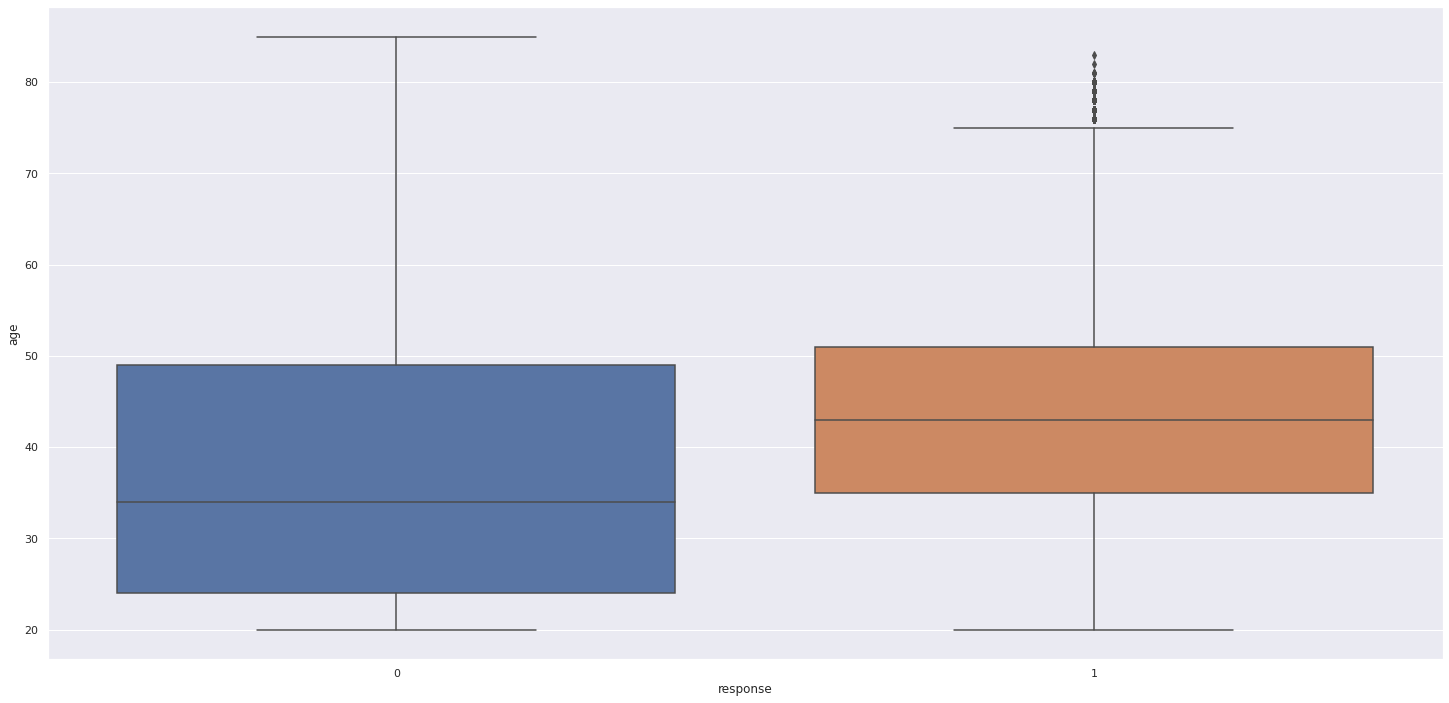

In [20]:
# age
sns.boxplot(x ='response' , y = 'age' , data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

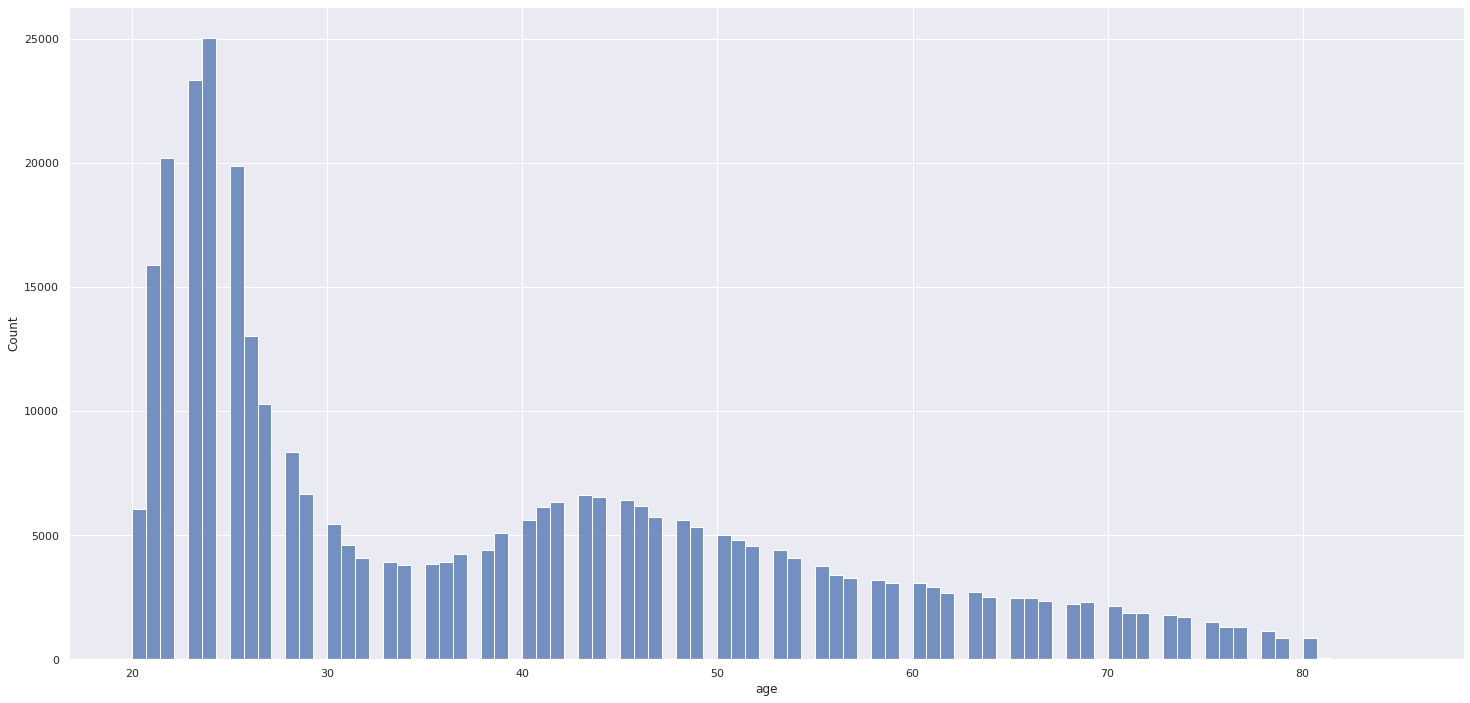

In [21]:
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

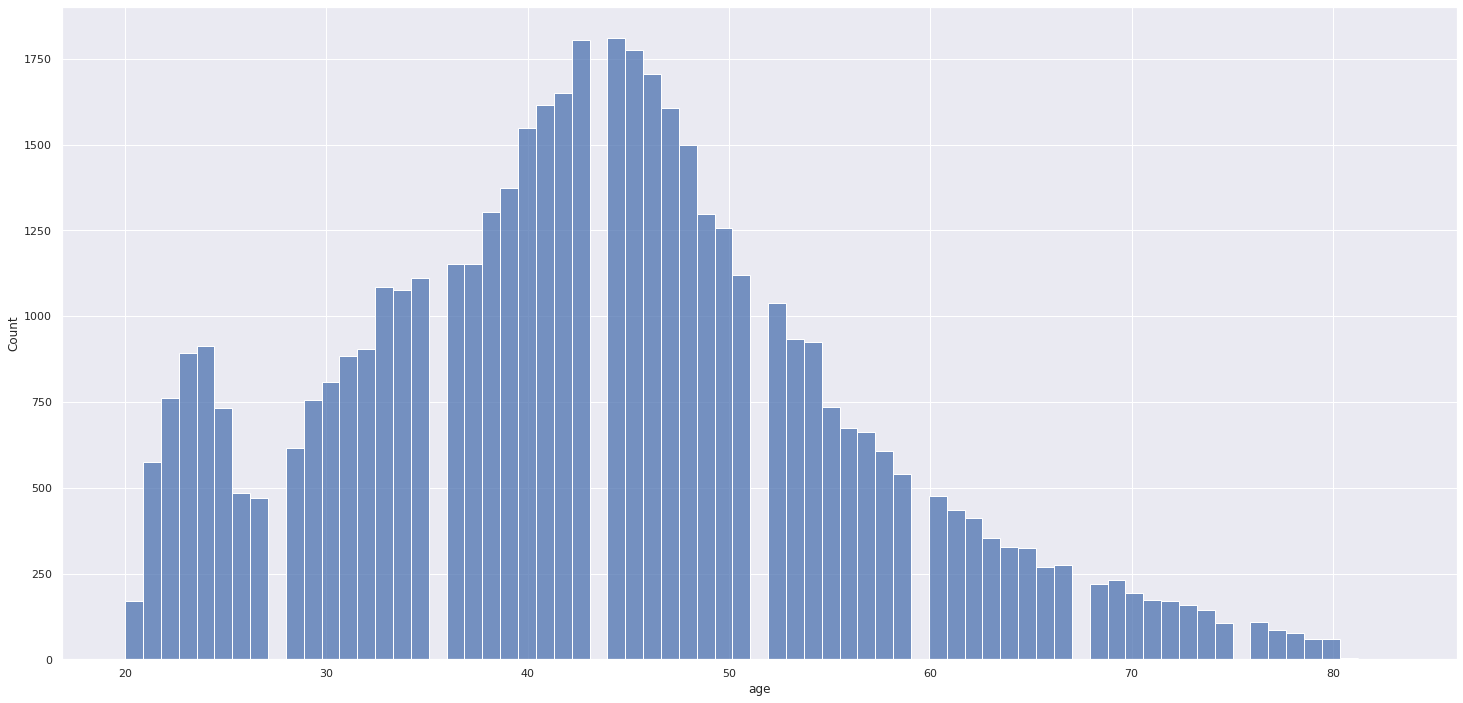

In [22]:
aux00 = df4.loc[df4['response'] == 1,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

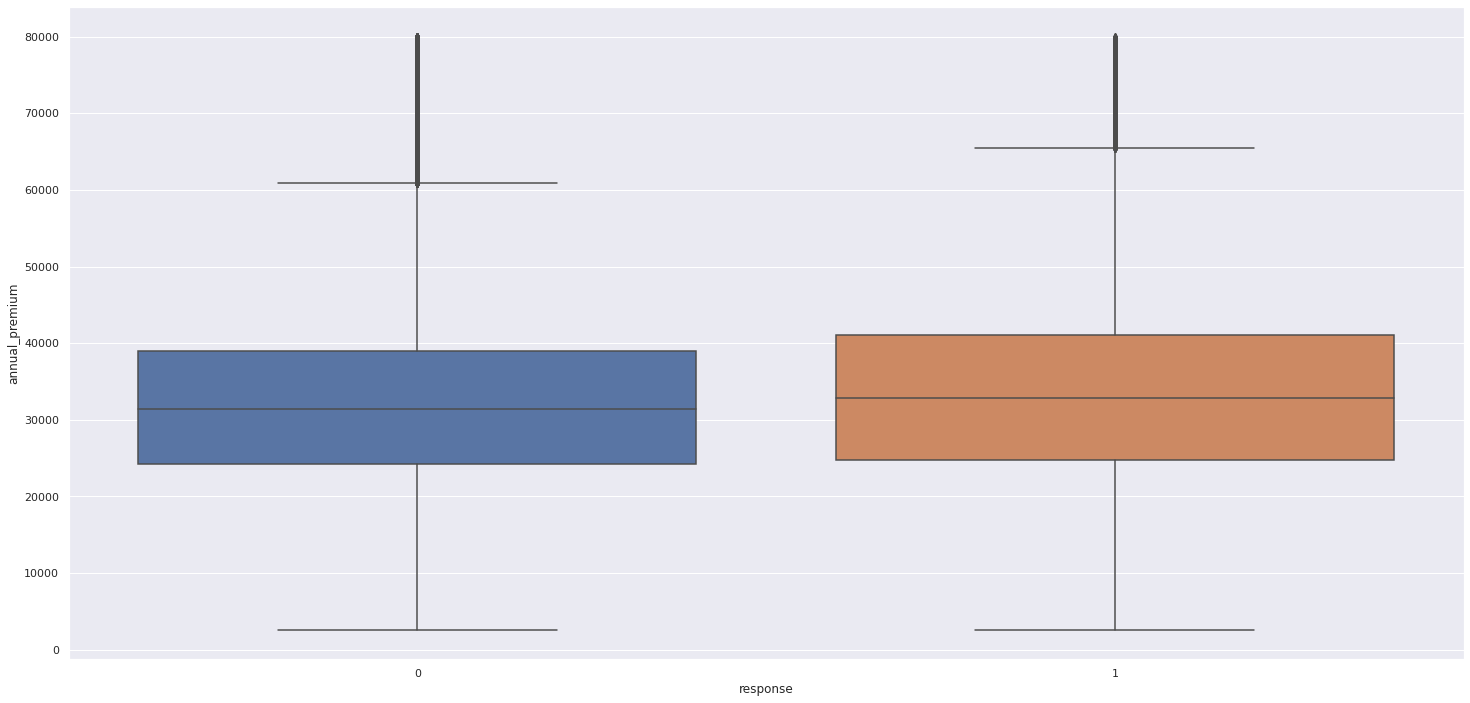

In [23]:
# annual_premium

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x ='response' , y = 'annual_premium' , data=aux)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

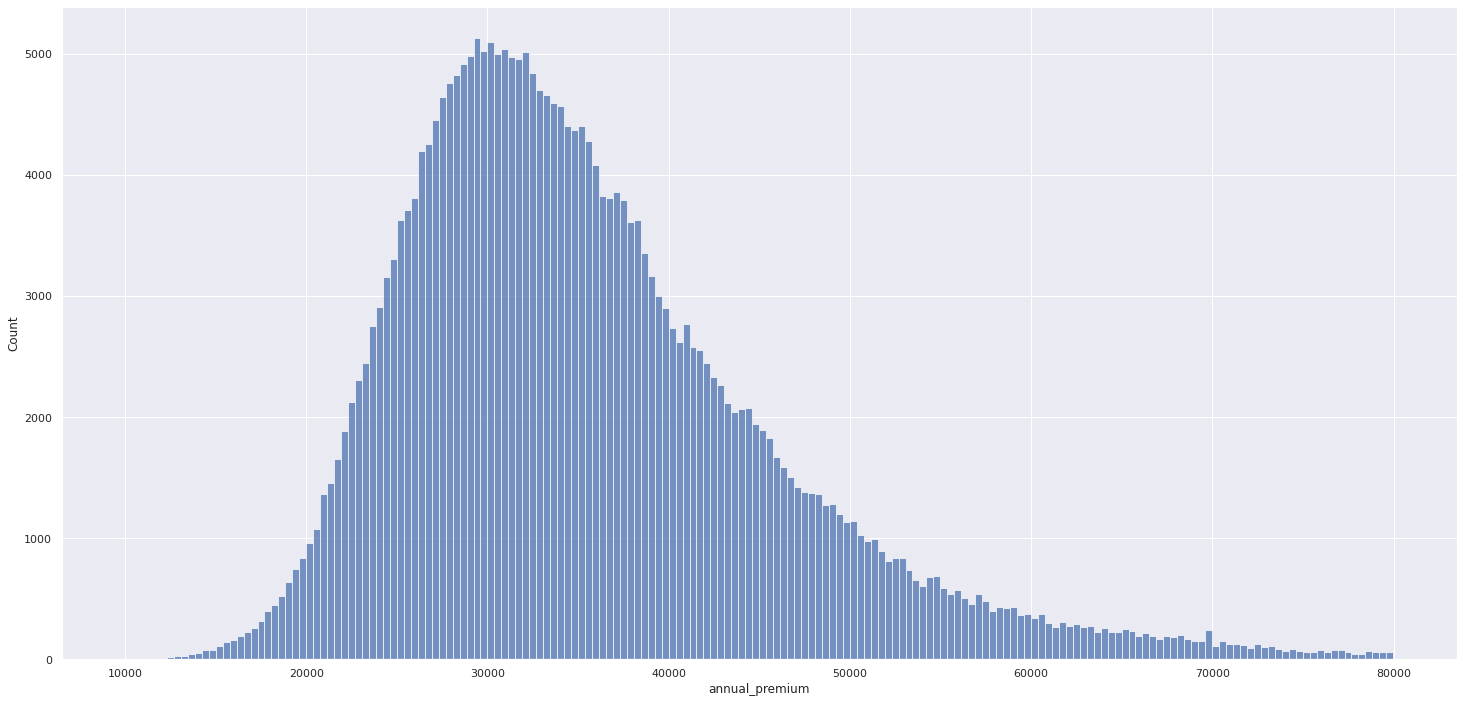

In [24]:
aux = df4[(df4['annual_premium']  > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0,'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

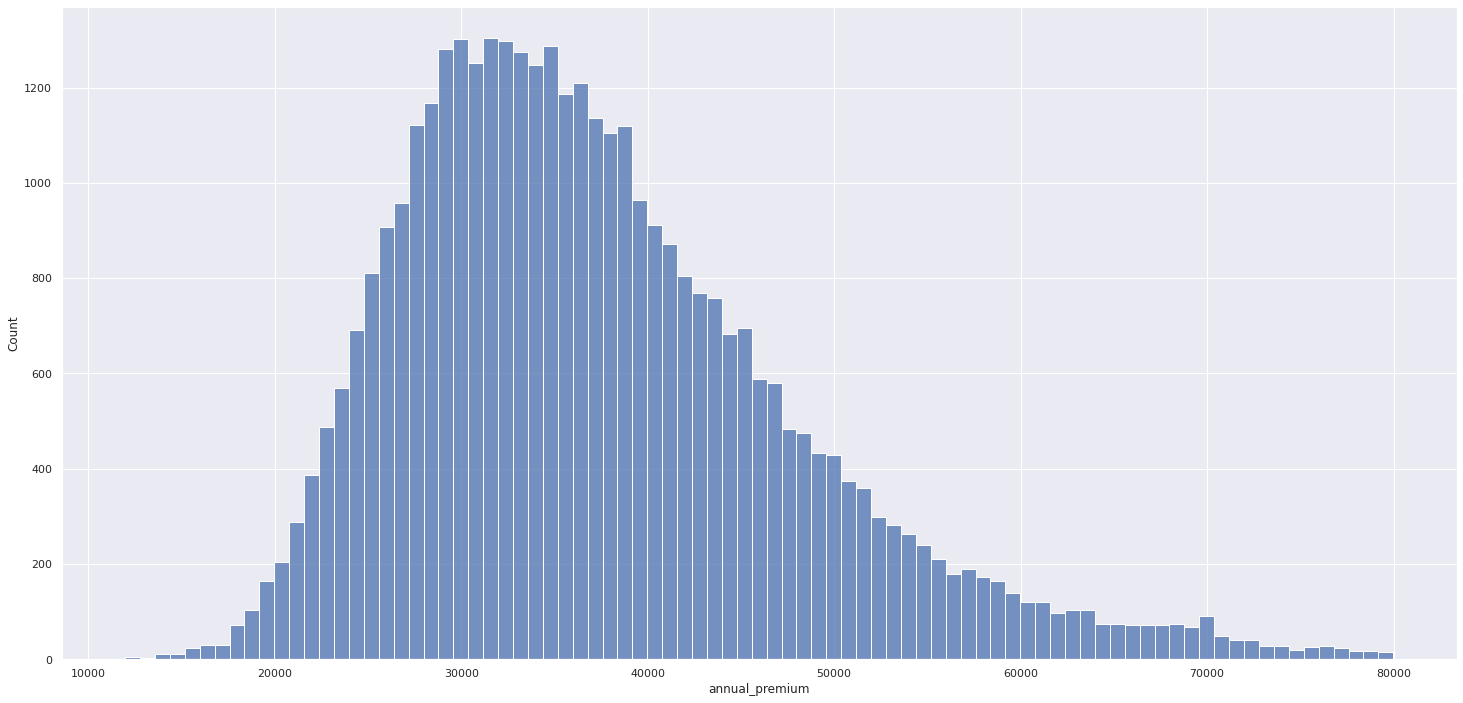

In [25]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1,'annual_premium']
sns.histplot(aux00)

In [26]:
# driving_license

aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux.head()   
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# sns.barplot(x ='response' , y = 'driving_license' , data=aux)


In [27]:
aux

,response,driving_license,driving_license_perc
0,0,333628,0.87728276
1,1,46669,0.12271724


<AxesSubplot:xlabel='region_code', ylabel='id'>

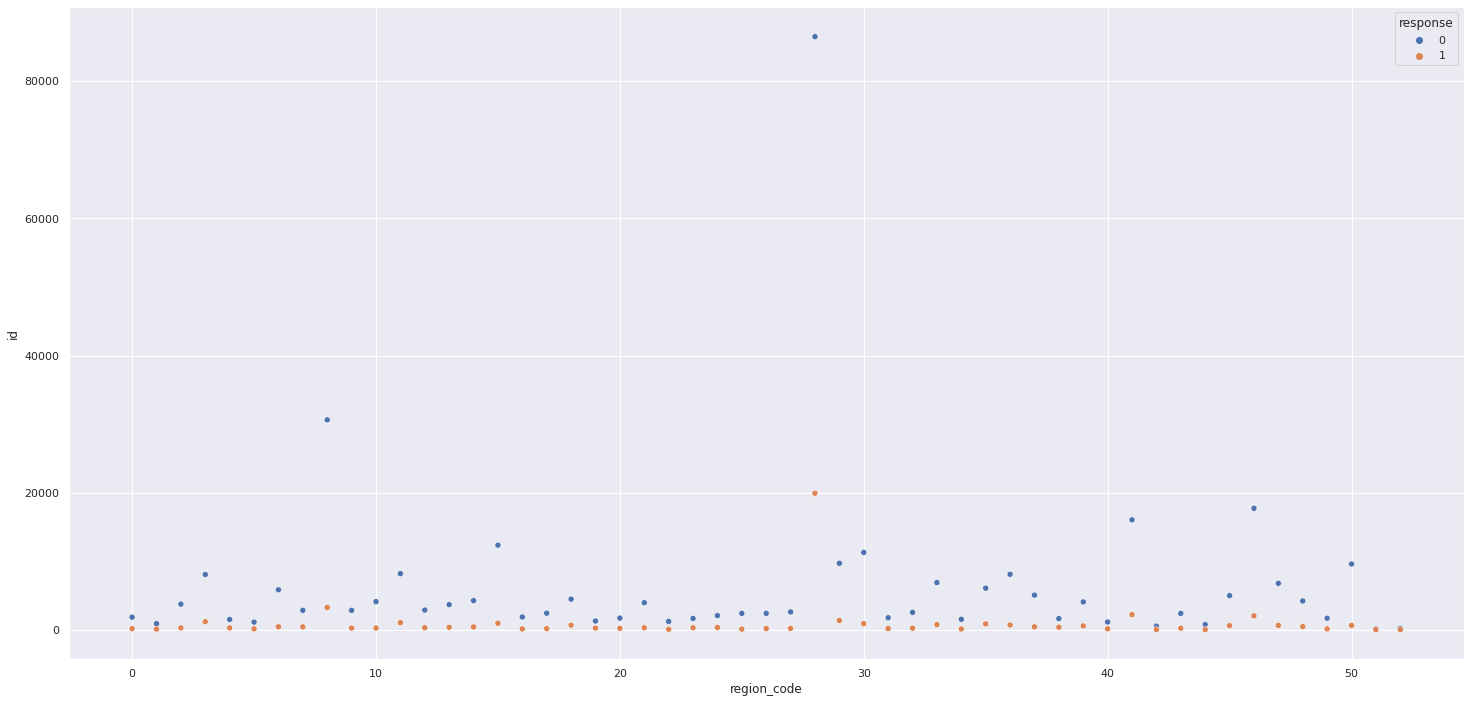

In [28]:
# region_code

aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()


sns.scatterplot(x= 'region_code' , y='id' , hue='response' , data=aux0)

In [29]:
# previously_insured

pd.crosstab(df4['previously_insured'],df4['response'] ).apply(lambda x: x / x.sum() , axis =1)

response,0,1
previously_insured,,
0,0.77454584,0.22545416
1,0.99909522,0.00090478


In [30]:
# vehicle_age

df4[['vehicle_age' , 'response']].value_counts(normalize= True).reset_index()


,vehicle_age,response,0
0,between_1_2_year,0,0.43428520
1,below_1_year,0,0.41348800
2,between_1_2_year,1,0.09132820
3,over_2_years,0,0.02966343
4,below_1_year,1,0.01889748
5,over_2_years,1,0.01233768


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

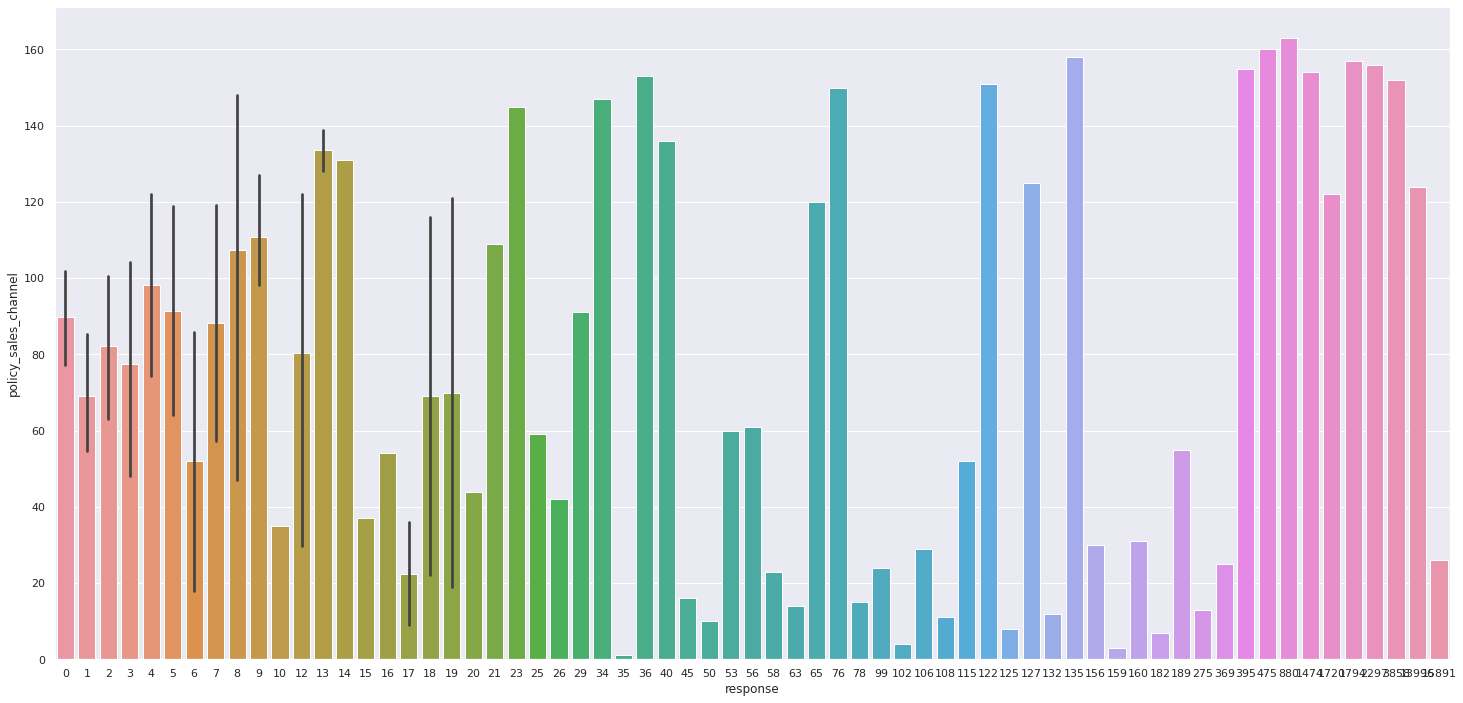

In [31]:
# policy_sales_channel

aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x ='response' , y= 'policy_sales_channel' , data=aux0) 

<AxesSubplot:xlabel='response', ylabel='vintage'>

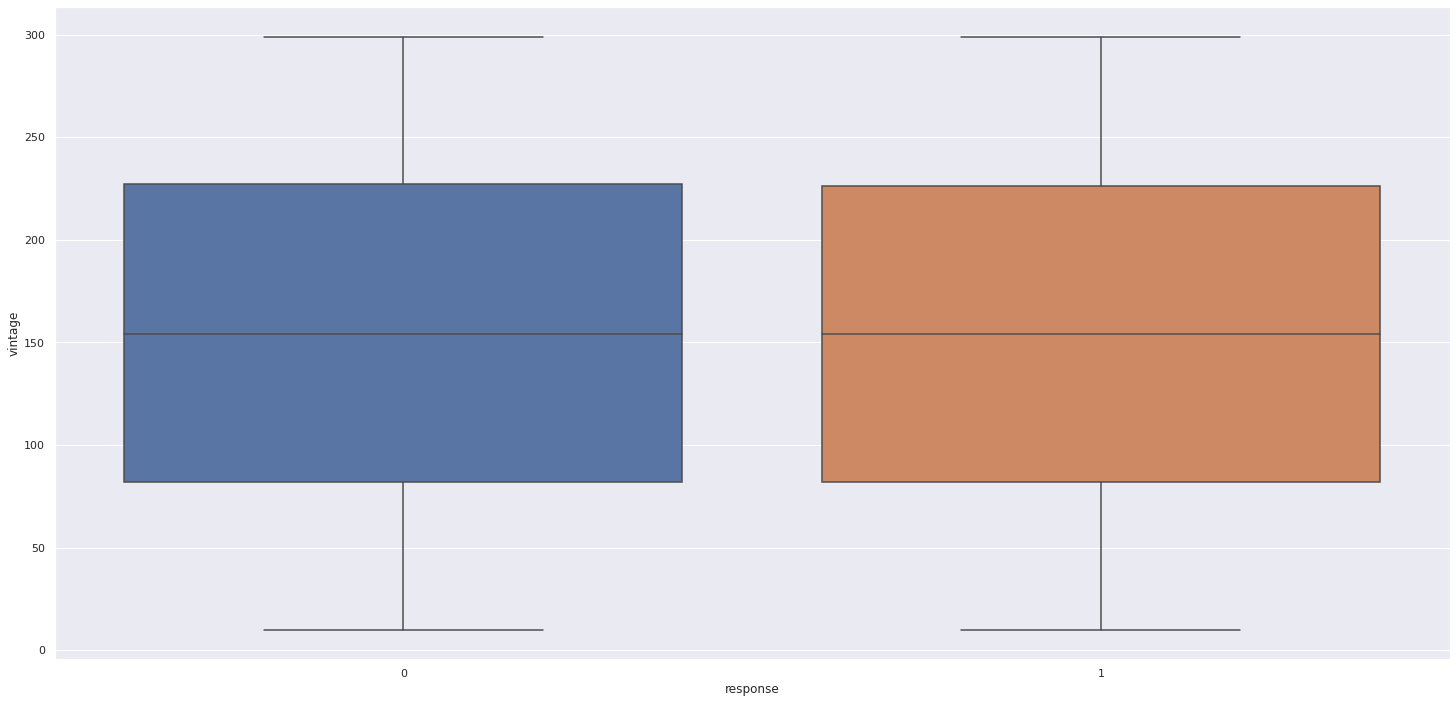

In [32]:
# vintage


sns.boxplot(x ='response' , y = 'vintage' , data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

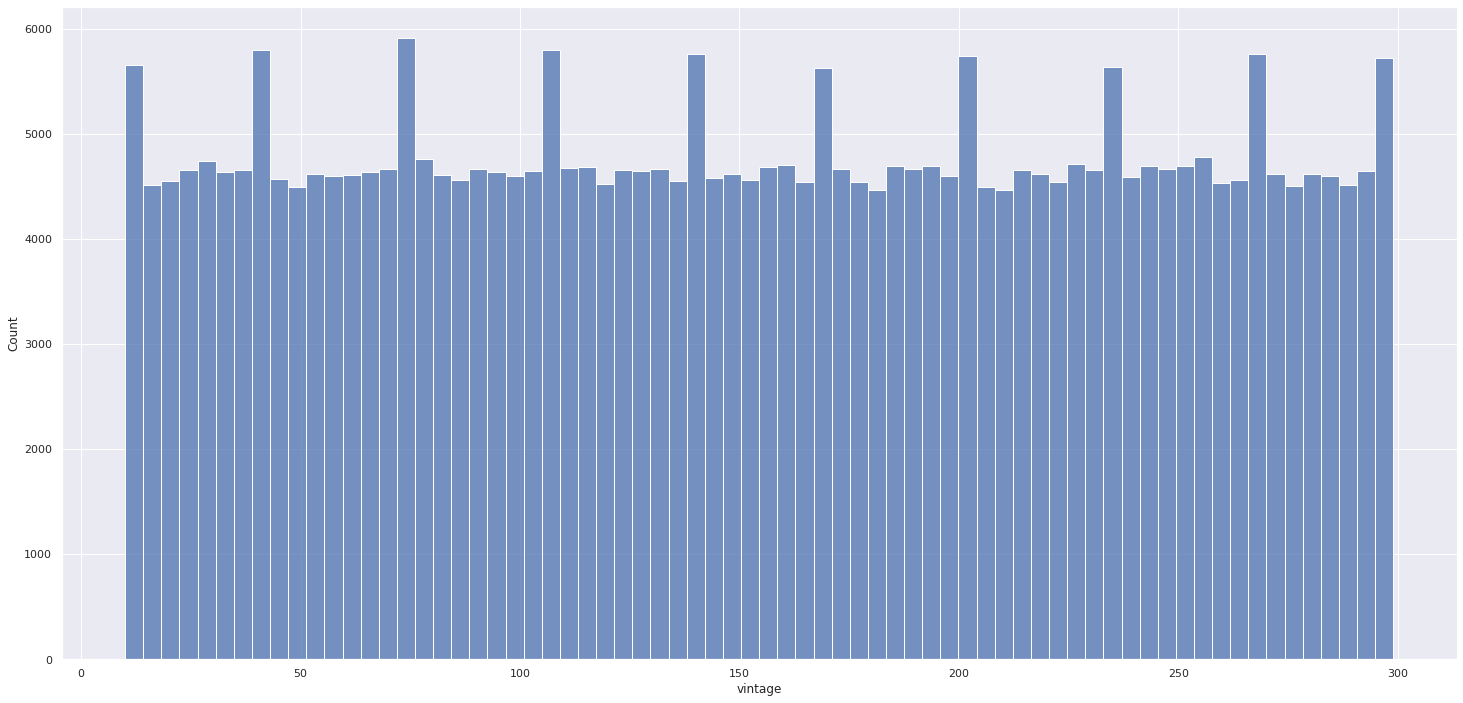

In [33]:
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

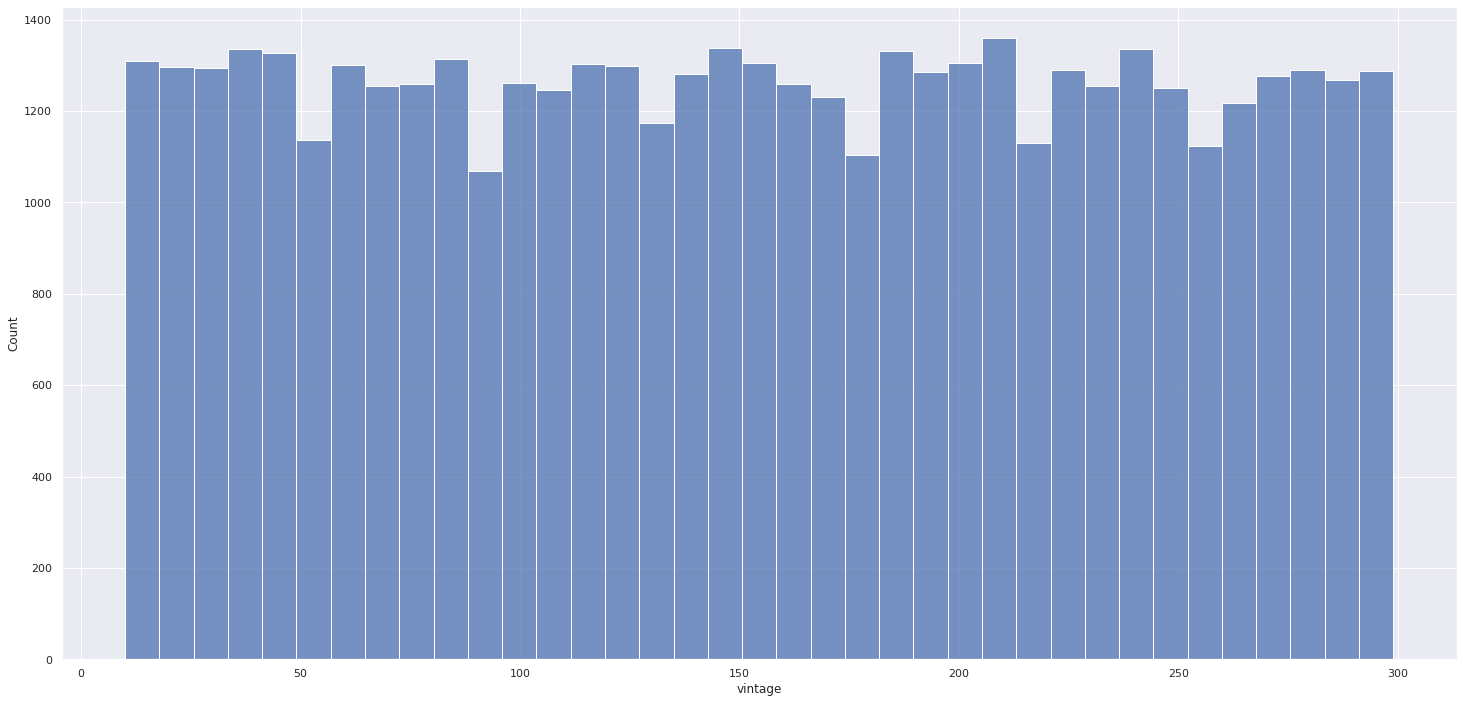

In [34]:
aux00 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot(aux00)

## 4.2. Bivariate Analysis


# 5.0. Data Preparation


In [35]:
df5 = df4.copy()

In [36]:
x = df4.drop('response' , axis=1)
y = df4['response'].copy()


x_train,x_val,y_train,y_val = ms.train_test_split(x,y, test_size = 0.20)

df5 = pd.concat([x_train,y_train], axis=1)

## 5.1. Standardization


In [37]:
ss =pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2. Rescaling


In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3. Encoder


In [39]:
# gender - Target encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[: , 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[: , 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5 , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
df5 = df5.fillna(0)

## 5.4. Validation Preparation

In [40]:
# gender
x_val.loc[: , 'gender'] = x_val.loc[: , 'gender'].map(target_encode_region_code)

# Age
x_val.loc[: , 'gender'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val['vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# region_code 
x_val.loc[: , 'region_code'] = x_val.loc[: , 'region_code'].map(target_encode_region_code)

# annual_premium
x_val['annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# vehicle_age 
x_val = pd.get_dummies(x_val , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel 
x_val.loc[: , 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)


# 6.0. Feature Selection


## 6.1. Feature Importancia

In [41]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis= 1)
y_train_n = y_train.values
forest.fit(x_train_n , y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                        feature  importances
0                       vintage   0.27075892
0                annual_premium   0.24358541
0                           age   0.16641799
0                   region_code   0.10732581
0                vehicle_damage   0.06706693
0          policy_sales_channel   0.05928351
0            previously_insured   0.05707957
0      vehicle_age_below_1_year   0.01465872
0  vehicle_age_between_1_2_year   0.00636931
0                        gender   0.00474404
0      vehicle_age_over_2_years   0.00222555
0               driving_license   0.00048424


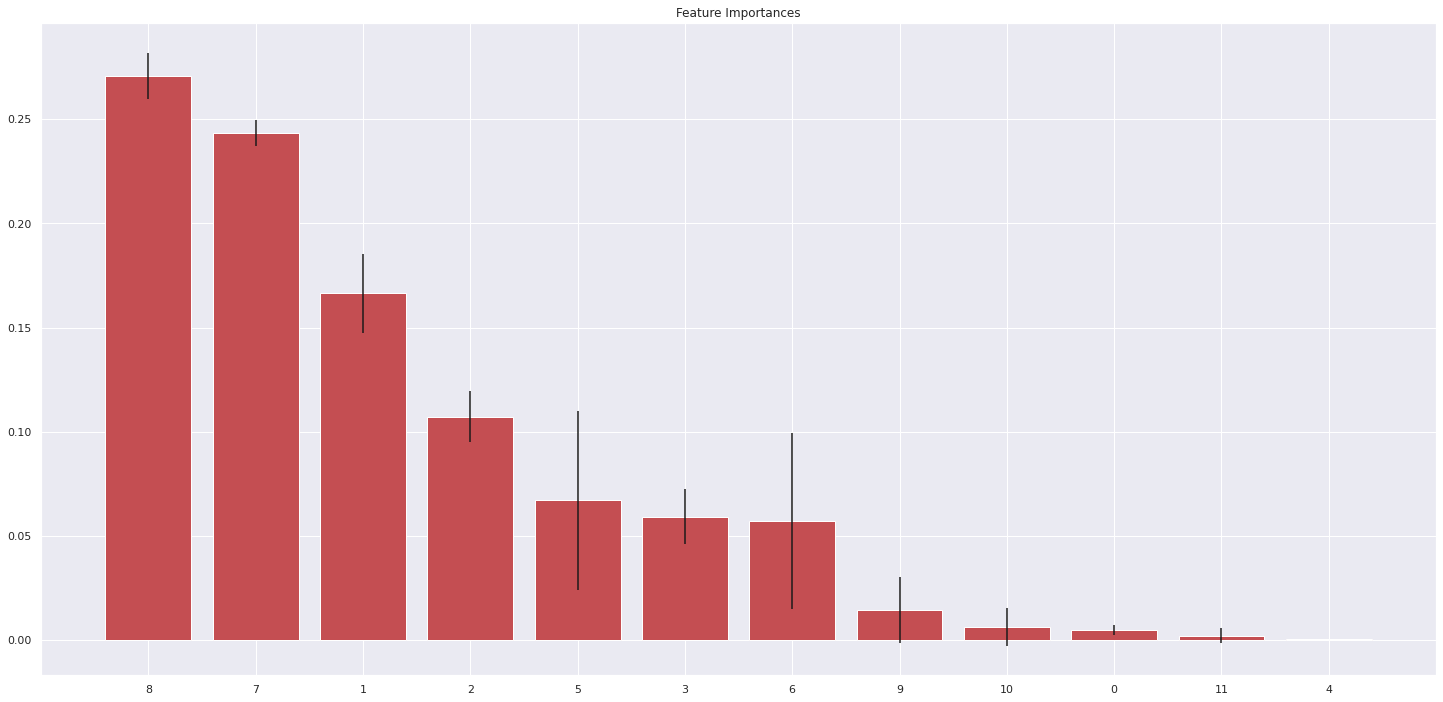

In [42]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis= 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df =pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr= std[indices], align= 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Modelling


In [43]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

x_train = df5[cols_selected]
x_validation = x_val[cols_selected]
y_validation = y_val.copy()

## 7.1. KNN

In [44]:
# model definition - KNN
knn_model = nk.KNeighborsClassifier(n_neighbors = 500)

# model training
knn_model.fit(x_train , y_train)

# model prediction
yhat_knn = knn_model.predict_proba (x_validation)


## 7.2. Logistic Regression

In [45]:
# model definition - Logistic Regression
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train , y_train)

# model prediction
yhat_lr = lr_model.predict_proba (x_validation)

## 7.3. Extra Trees

In [46]:
# model definition
ET = en.ExtraTreesClassifier( n_estimators=300, n_jobs=-1, random_state=42 )

# model fit
ET.fit(x_train , y_train)

# model predict
yhat_et = ET.predict_proba(x_validation)

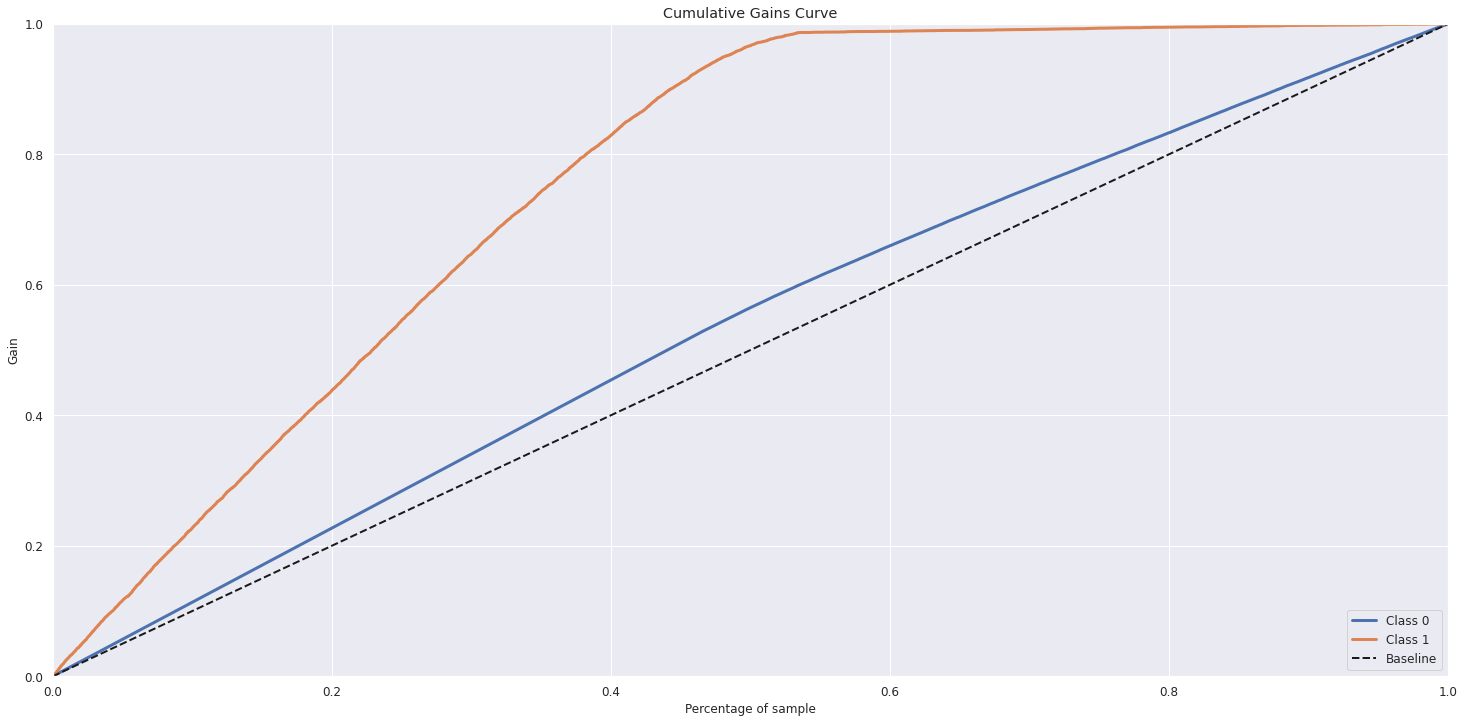

In [47]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_et);

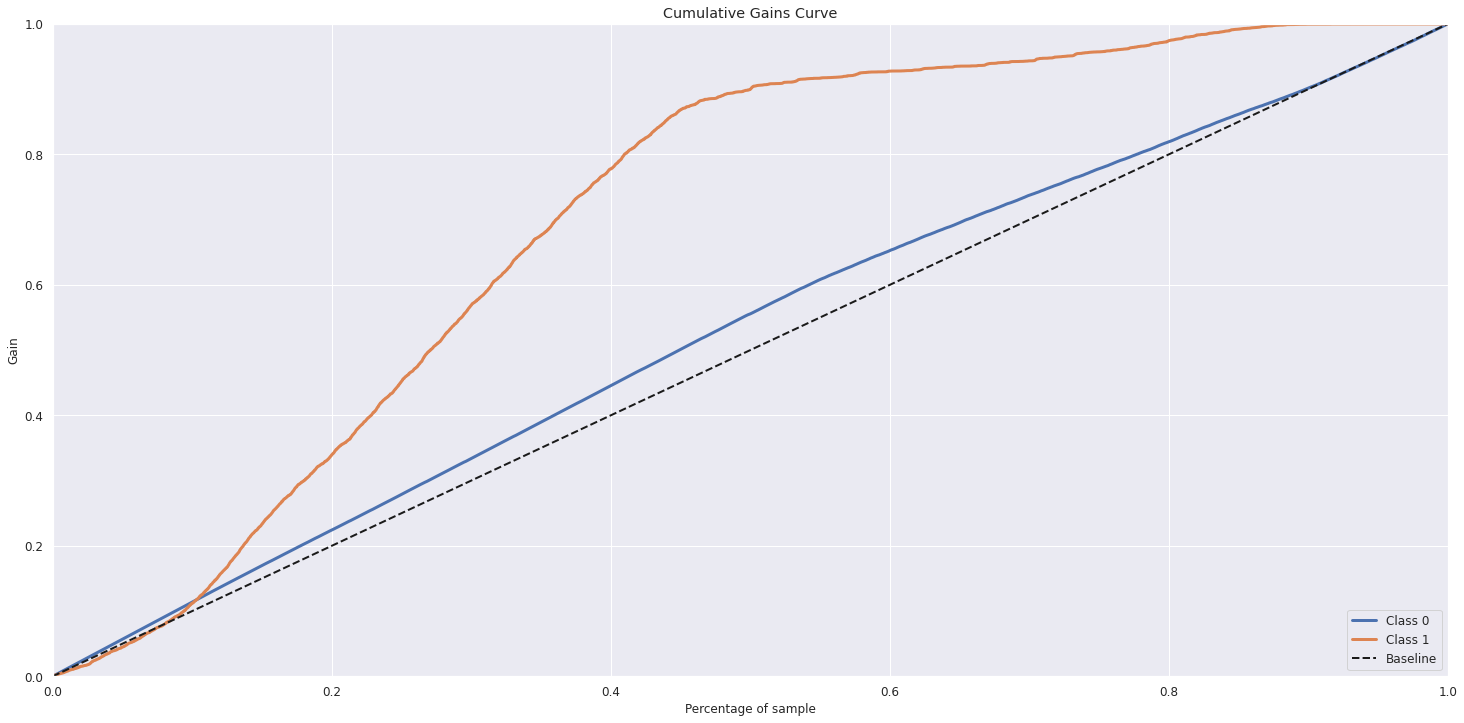

In [48]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_lr);

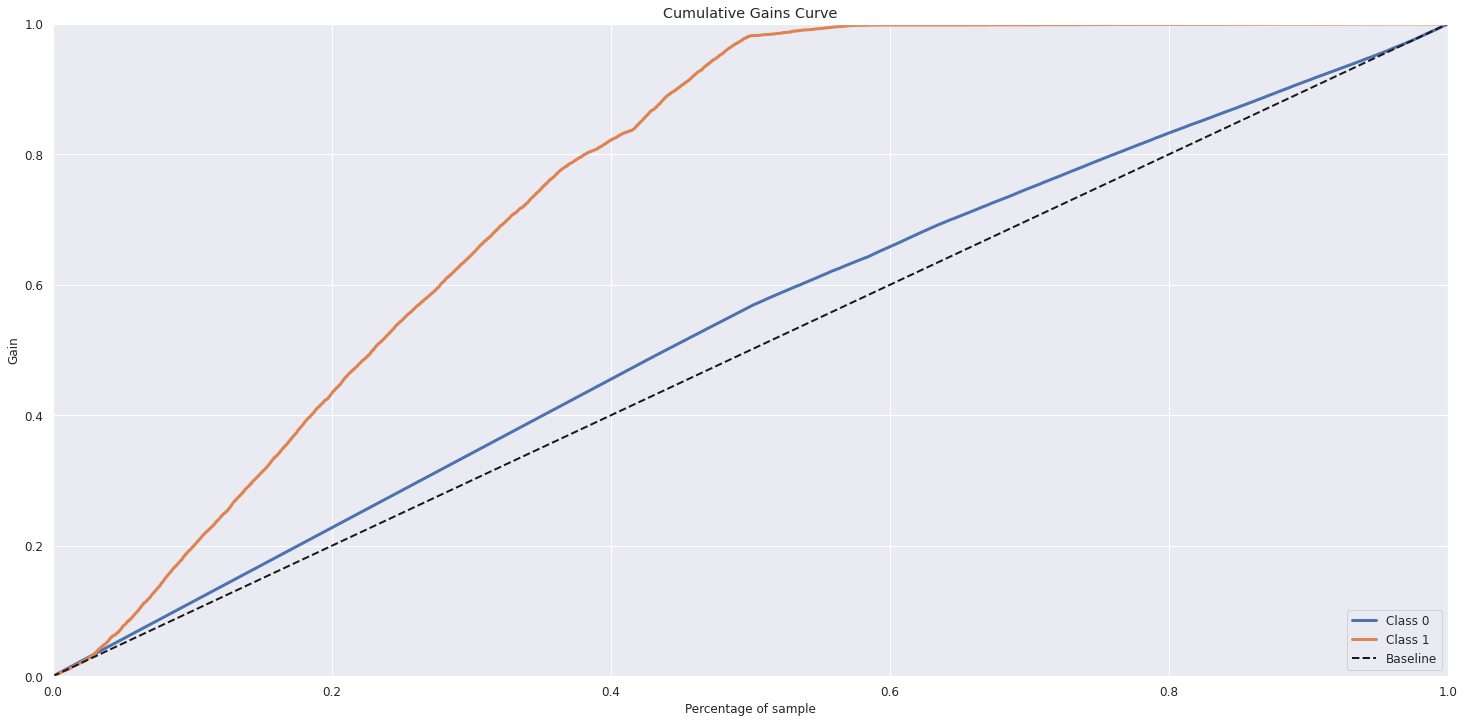

In [49]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_knn);

# 8.0. Performance Metrics


In [50]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

In [51]:
df8.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response
105277,0.70588235,0.12002055,49,0.11343882,1,0.20898234,0,1
219057,0.13494810,1.23410579,59,0.18673522,1,0.20898234,0,1
183871,0.03806228,-1.62211463,30,0.07868526,0,0.35359986,1,0
321822,0.61591696,4.02359155,51,0.18673522,0,0.02611131,1,0
48264,0.50519031,0.34504658,24,0.09629086,0,0.35359986,1,0


In [52]:

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )


Precision at K: 0.2549019607843137
Recall at K: 0.0013975489142119973


# 9.0. Deploy to Production
